In [17]:
import os
import tensorflow as tf
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

np.set_printoptions(suppress=True, precision=2)
from data_processing.Processor import load_detection_ds, Processor
from matplotlib import cm as mp_cm
import cv2
import tqdm
import json
import pandas as pd
from data_processing import image, bboxes
from utils.draw_bboxes import draw_bboxes
from models.fcos import build
from data_processing.io import load_gmc
from models.fcos.interpreter import Interpreter
from data_processing.nms import nms
from data_processing import io
from data_processing.BboxDetectionReport import BboxDetectionReport

In [18]:
raw_ds = load_detection_ds("training/val_dataset.yaml")

for sample in raw_ds:
    break

In [19]:
sample_size = (300,400) # Change if not the same

In [44]:
processor = Processor([
    image.LoadImage(),
    bboxes.LoadBboxes(n_bboxes=90),
    image.ResizeKeepRatio(sample_size[0],sample_size[1]),
    image.Normalize(),
    bboxes.BuildFCOSTarget(sample_size, [8])
], feature_keys=None)

# Detection Report

In [21]:
# Build model and load weights

model_id = 'e54187eb38901dbfca1ee4477a35280c'
model = build.build_model()
model.load_weights('models/fcos/snapshots/{}/weights.hdf5'.format(model_id))

In [22]:
# Iterate through validation dataset and save predictions into jsons

interpreter = Interpreter('configs/interpreter.yaml')

bs = 1
for sample in tqdm.tqdm_notebook(raw_ds.map(processor).batch(bs)):
    raw_pred = model(sample['img'])
    bboxes_pred = interpreter(raw_pred,  sample["src_img_bbox"].numpy(), sample["original_shape"].numpy())
    bboxes_pred = nms(bboxes_pred, 0.2)
    io.serialize(sample['img_path'].numpy(), bboxes_pred, 'data/images', 'data/logs/val_report')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [27]:
# Get default report

report = BboxDetectionReport()
report.from_serialized_report('data/images_markup', 'data/logs/val_report', class_idx = 0)
standard_report = report.run_standard_evaluation()

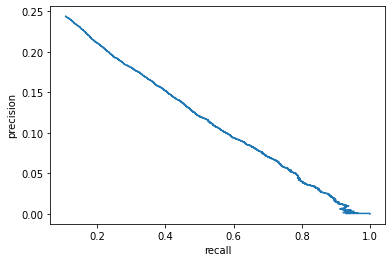

In [61]:
# Plot precision-recall curve

plt.plot(report.precision_recall_curve()[0],
        report.precision_recall_curve()[1])
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

In [34]:
# Prepare report for saving into dataframe

report_df = pd.read_csv('data/snapshots_template.csv')

report_df['idea'] = "First try of training in Colab" # Replace every time
df['model'] = 'fcos_v0.py' # The same


df['snapshot_id'] = model_id
df['input_size'] = str(sample_size)

df['pfr@0.3'] = standard_report['precision_at_.3recall.5IoU']
df['pfr@0.5'] = standard_report['precision_at_.5recall.5IoU']
df['pfr@0.8'] = standard_report['precision_at_.8recall.5IoU']
df['pfr@0.9'] = standard_report['precision_at_.9recall.5IoU']
df['rfp@0.3'] = standard_report['recall_at_.3precision.5IoU']
df['rfp@0.5'] = standard_report['recall_at_.5precision.5IoU']
df['rfp@0.8'] = standard_report['recall_at_.8precision.5IoU']
df['rfp@0.9'] = standard_report['recall_at_.9precision.5IoU']

df.head()

,snapshot_id,idea,input_size,model,pfr@0.3,pfr@0.5,pfr@0.8,pfr@0.9,rfp@0.3,rfp@0.5,rfp@0.8,rfp@0.9
0,e54187eb38901dbfca1ee4477a35280c,0.0,"(300, 400)",fcos_v0.py,0,0,0,0,0.183,0.123,0.044,0.02


In [38]:
# Save report into dataframe with all reports

snapshots_df_path = 'data/snapshots.csv'
if os.path.exists(snapshots_df_path):
    snapshots = pd.read_csv(snapshots_df_path)
    updated_snapshots = pd.concat([snapshots,df],axis=0)
    updated_snapshots.to_csv(snapshots_df_path,index=False)
else:
    df.to_csv(snapshots_df_path, index=False)

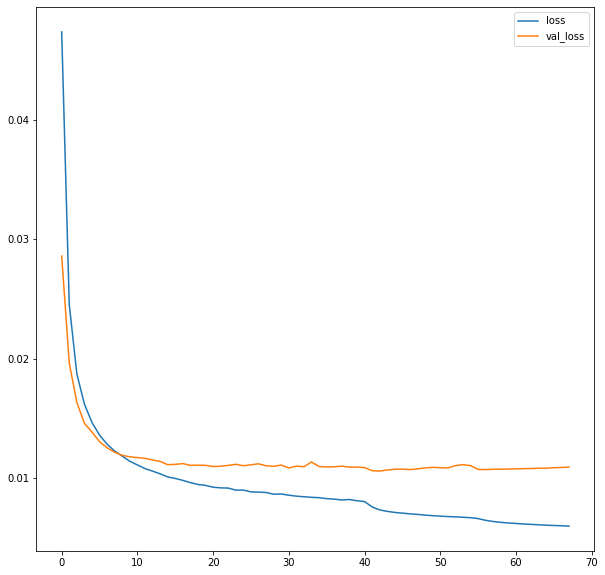

In [58]:
# Show graphs of loss and val_loss

with open('models/fcos/snapshots/{}/history.json'.format(model_id), 'r') as fp:
    history_json = json.load(fp)
    
epochs = len(history_json['loss'])

x_axis = np.arange(epochs)
plt.figure(figsize=(10,10))
plt.plot(x_axis, history_json['loss'])
plt.plot(x_axis, history_json['val_loss'])
plt.legend(['loss','val_loss'])
plt.show()

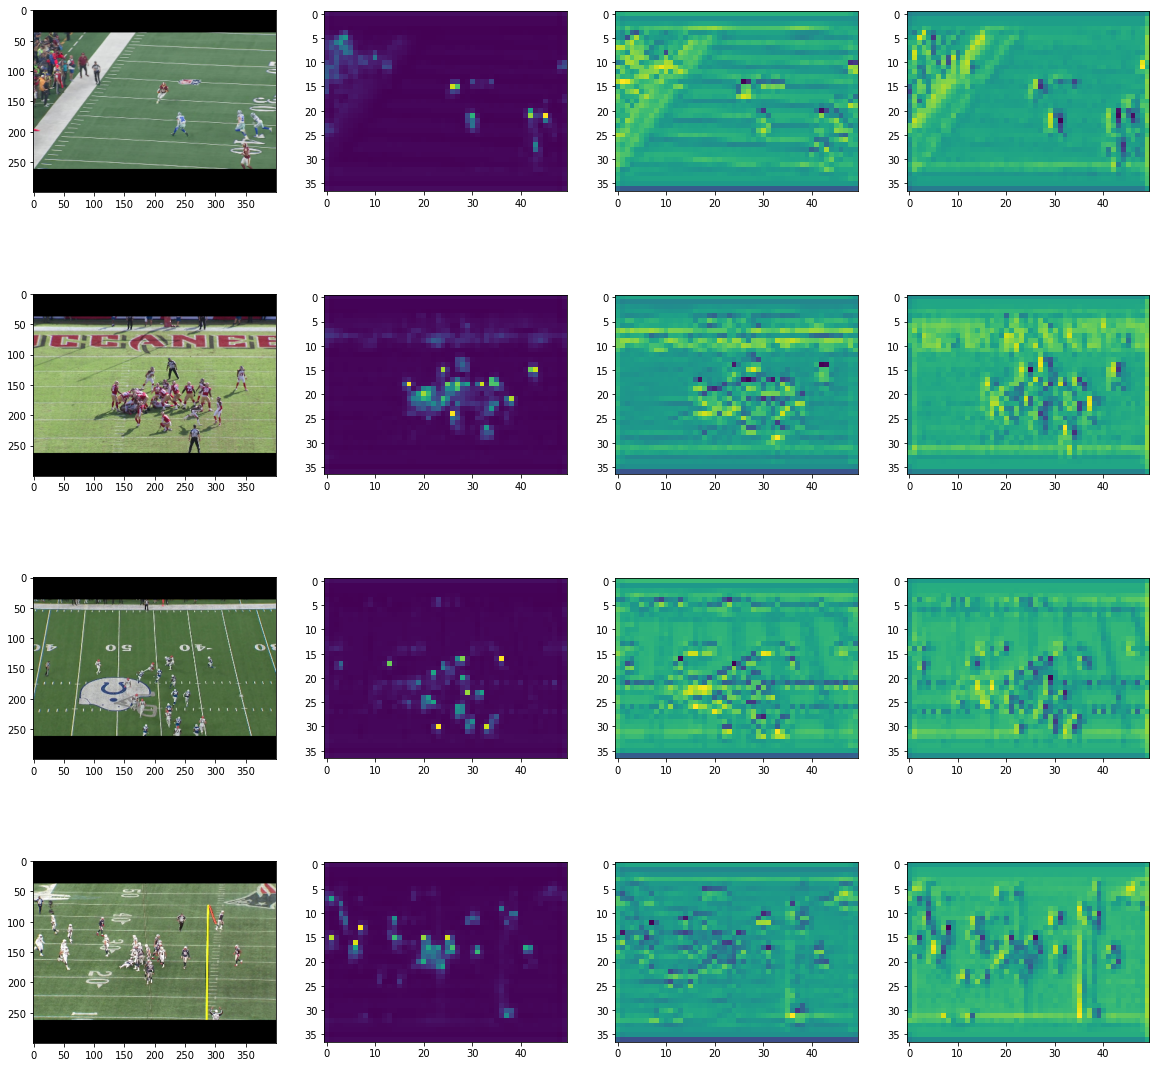

In [59]:
# Get a glimpse of prediction on 4 samples from validation dataset

raw_preds = []
bboxes_preds = []
sample_imgs = []
k = 0
for sample in raw_ds.map(processor).batch(1):
    sample_imgs.append(sample['img'][0].numpy())
    raw_preds.append(model(sample['img']))
    bboxes_pred = interpreter(raw_pred,  sample["src_img_bbox"].numpy(), sample["original_shape"].numpy())
    bboxes_pred = nms(bboxes_pred, 0.2)
    bboxes_preds.append(bboxes_pred)
    k += 1
    if k > 3:
        break

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(20,20))
pred_index = 0
for col in ax:
    col[0].imshow(sample_imgs[pred_index])
    col[1].imshow(raw_preds[pred_index][0][:,:,0])
    col[2].imshow(raw_preds[pred_index][0][:,:,1])
    col[3].imshow(raw_preds[pred_index][0][:,:,2])
    pred_index += 1
plt.show()

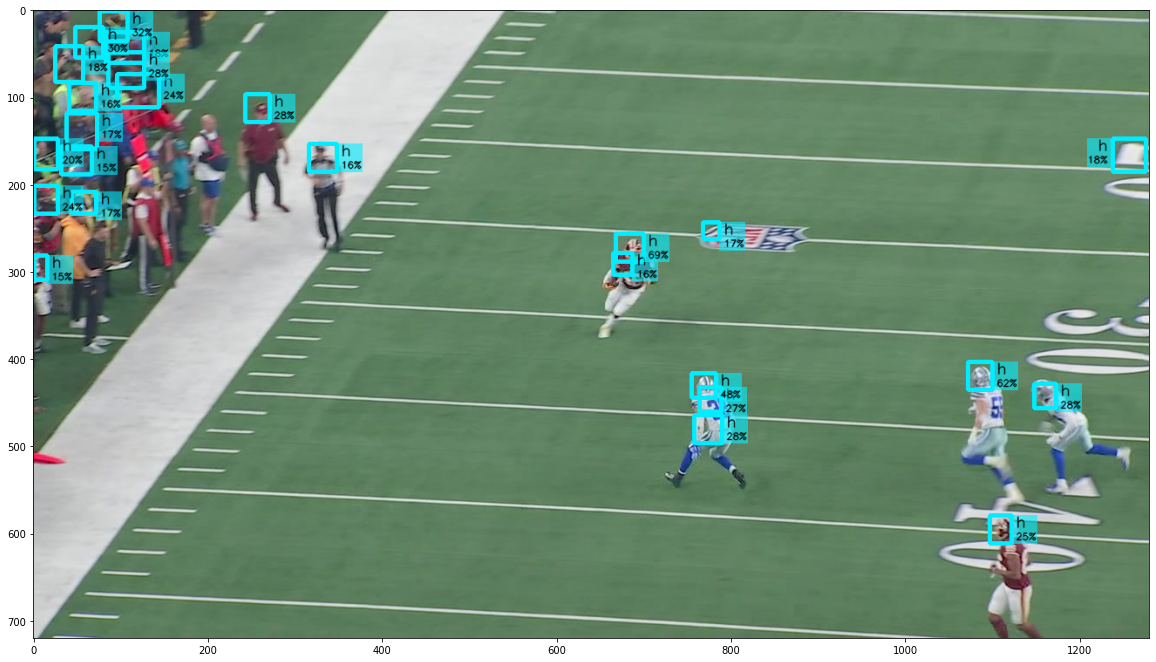

In [70]:
# Show prediction example

for sample in raw_ds.shuffle(1, reshuffle_each_iteration=True).map(processor).batch(bs):
    raw_pred = model(sample['img'])
    bboxes_pred = interpreter(raw_pred,  sample["src_img_bbox"].numpy(), sample["original_shape"].numpy())
    bboxes_pred = nms(bboxes_pred, 0.2)
    break
    
plt.figure(figsize=(20,20))
plt.imshow(draw_bboxes(
    cv2.cvtColor(cv2.imread(sample['img_path'][0].numpy().decode('utf-8')), cv2.COLOR_BGR2RGB),
    bboxes_pred[0]))
plt.show()